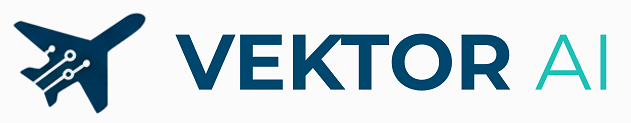

# **Modelos Predictivos 1 - Random Forest y Regresión Logística**

Se realizaron diversos intentos para ambos tipos de modelos (Random Forest y Regresión Logística). El mejor modelo exportado correspondió al Intento 4 de Random Forest. Sin embargo, falló a la hora de realizar predicciones en Backend, por lo que se siguieron realizando más pruebas de modelos en posteriores notebooks, además de incluirse las quince aerolíneas disponibles en el período entre octubre de 2024 y septiembre de 2025.

# **Descripción de las Variables**

**Time Period:**

QUARTER: Quarter (1-4)

MONTH: Month

DAY_OF_MONTH: Day of the Month

DAY_OF_WEEK: Day of the week

FL_DATE: Flight Date (yyymmdd)

**Airline**

OP_UNIQUE_CARRIER: Unique Carrier Code. When the same code has been used by multiple carriers, a numeric suffix is used for earlier users, for example, PA, PA(1), PA(2). Use this field for analysis across a range of years.

TAIL_NUM: Tail Number

OP_CARRIER_FL_NUM: Flight Number

**Origin**

ORIGIN_AIRPORT_ID: Origin Airport, Airport ID. An identification number assigned by US DOT to identify a unique airport. Use this field for airport analysis across a range of years because an airport can change its airport code and airport codes can be reused.

ORIGIN: Origin Airport

**Destination**

DEST_AIRPORT_ID: Destination Airport, Airport ID. An identification number assigned by US DOT to identify a unique airport. Use this field for airport analysis across a range of years because an airport can change its airport code and airport codes can be reused.

DEST: Destination Airport

**Departure Performance**

CRS_DEP_TIME: CRS Departure Time (local time: hhmm)

DEP_TIME: Actual Departure Time (local time: hhmm)

DEP_DELAY: Difference in minutes between scheduled and actual departure time. Early departures show negative numbers.

DEP_DEL15: Departure Delay Indicator, 15 Minutes or More (1=Yes)

**Arrival Performance**

CRS_ARR_TIME: CRS Arrival Time (local time: hhmm)

ARR_TIME: Actual Arrival Time (local time: hhmm)

ARR_DELAY: Difference in minutes between scheduled and actual arrival time. Early arrivals show negative numbers.

ARR_DEL15: Arrival Delay Indicator, 15 Minutes or More (1=Yes)

**Flight Summaries**

ACTUAL_ELAPSED_TIME: Elapsed Time of Flight, in Minutes

**Cause of Delay (Data starts 6/2003)**

CARRIER_DELAY: Carrier Delay, in Minutes

WEATHER_DELAY: Weather Delay, in Minutes

NAS_DELAY: National Air System Delay, in Minutes

SECURITY_DELAY: Security Delay, in Minutes

LATE_AIRCRAFT_DELAY: Late Aircraft Delay, in Minutes

**Gate Return Information at Origin Airport (Data starts 10/2008)**

HAS_FIRST_DEP_TIME: First Gate Departure Time at Origin Airport

HAS_TOTAL_ADD_GTIME Total Ground Time Away from Gate for Gate Return or Cancelled Flight

FECHA_PARTIDA  para Backend ("YYYY-MM-DD-TH:M:S")

# **0. Importación de Datos**

In [ ]:
# The following code will only execute
# successfully when compression is complete

import kagglehub

# Download latest version
path = kagglehub.dataset_download("spmv1980/hackaton-2025-equipo-71", force_download=True)

print("Path to dataset files:", path)

100%|██████████| 990M/990M [00:26<00:00, 38.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/spmv1980/hackaton-2025-equipo-71/versions/13


In [ ]:
# Revisar contenido de la carpeta descargada
import os

for root, dirs, files in os.walk(path):
    print(f"\nDirectory: {root}")
    for file in files:
        print("  ", file)


Directory: /root/.cache/kagglehub/datasets/spmv1980/hackaton-2025-equipo-71/versions/13
   tail_map.csv
   flight_delays_one_year.csv
   flight_delays_15_aerolineas.csv
   df_procesado.csv
   df_procesado_todas las aerolneas.csv
   flight_delays_one_year_2a.csv


In [ ]:
import pandas as pd

# Transtat Octubre 2024 a Septiembre 2025  variables- 2 aerolineas ( registros)
df= pd.read_csv(os.path.join(path +"/df_procesado.csv"))

# **1. Codificación de Variables**

## OP_UNIQUE_CARRIER  (DL= 1 y WN=2)

In [ ]:
df["OP_UNIQUE_CARRIER"].value_counts()

,count
OP_UNIQUE_CARRIER,
WN,1371683
DL,1009364


In [ ]:
df["OP_UNIQUE_CARRIER"] = df["OP_UNIQUE_CARRIER"].replace({
    "DL": 1,
    "WN": 2
})

/tmp/ipython-input-3749394398.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["OP_UNIQUE_CARRIER"] = df["OP_UNIQUE_CARRIER"].replace({


In [ ]:
df["OP_UNIQUE_CARRIER"].value_counts()


,count
OP_UNIQUE_CARRIER,
2,1371683
1,1009364


## FL_DATE

In [ ]:
df["FL_DATE"].dtype

dtype('O')

In [ ]:
df["FL_DATE"] = pd.to_datetime(df["FL_DATE"])
start_date = df["FL_DATE"].min()
start_date

Timestamp('2024-10-01 00:00:00')

In [ ]:
end_date = df["FL_DATE"].max()
end_date

Timestamp('2025-09-30 00:00:00')

In [ ]:
start_date = pd.to_datetime("2024-10-01")

df["FL_DATE_NUM"] = (df["FL_DATE"] - start_date).dt.days + 1

In [ ]:
df["FL_DATE"] = df["FL_DATE"].dt.strftime("%Y-%m-%d")

## DEP_TIME

In [ ]:
df["DEP_TIME"] = df["DEP_TIME"].astype(str).str.replace(r'\D', '', regex=True).str.zfill(4)

df["DEP_TIME_CODE"] = (
    df["DEP_TIME"].str[:2].astype(int) * 60 +
    df["DEP_TIME"].str[2:].astype(int) +
    1
)

## TAIL_NUM

In [ ]:
# Data principal
df["TAIL_NUM"] = df["TAIL_NUM"].astype(str)

# Tabla de conversión
tail_map = pd.read_csv(os.path.join(path +"/tail_map.csv"))

mapping = dict(zip(tail_map["TAIL_NUM"], tail_map["CODE"]))

df["TAIL_NUM_CODE"] = df["TAIL_NUM"].map(mapping)

# **2. Datos Train/test**

## **2.1. Split de los datos**

In [ ]:
import sklearn
print(f'Scikit-learn version: {sklearn.__version__}')

Scikit-learn version: 1.6.1


In [ ]:
from sklearn.model_selection import train_test_split

# Separación de features y target
X = df.drop(columns=['DEP_DEL15'])
y = df['DEP_DEL15']

# División train/test (70/30) con estratificación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# Verificación de tamaños
print(f'Tamaño Train: {X_train.shape}, {y_train.shape}')
print(f'Tamaño Test: {X_test.shape}, {y_test.shape}')

print()

# Verificación de proporción de clases
print('Ditribución DEP_DEL15 (total):')
print(y.value_counts(normalize=True))

print()

print('Ditribución y_train:')
print(y_train.value_counts(normalize=True))

print()

print('Ditribución y_test:')
print(y_test.value_counts(normalize=True))

Tamaño Train: (1666732, 26), (1666732,)
Tamaño Test: (714315, 26), (714315,)

Ditribución DEP_DEL15 (total):
DEP_DEL15
0.0    0.793701
1.0    0.206299
Name: proportion, dtype: float64

Ditribución y_train:
DEP_DEL15
0.0    0.793701
1.0    0.206299
Name: proportion, dtype: float64

Ditribución y_test:
DEP_DEL15
0.0    0.793702
1.0    0.206298
Name: proportion, dtype: float64


Conclusión:

* El conjunto de datos presenta un desbalance natural aproximado de 80/20 en la variable objetivo DEP_DEL15.

* La aplicación de un train/test split estratificado (```stratify = y```) preserva correctamente dicha distribución en ```y_train``` y ```y_test```, garantizando que ambas particiones mantengan proporciones representativas de vuelos puntuales y con retraso, lo cual resulta adecuado como punto de partida para las etapas posteriores de balanceo de train y modelado.

## **2.2. Label encoding (categóricas)**

In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [ ]:
# Reconoce las variables categóricas de X_train
categor = X_train.select_dtypes(include='object').columns

# Diccionario que guardará la codificación de cada columna
encoders = {}

# Revisa la cantidad de categorías por columna
for col in categor:
    print(col, X_train[col].nunique())

FL_DATE 365
TAIL_NUM 1841
ORIGIN 160
DEST 161
DEP_TIME 1393
FECHA_PARTIDA 399077


In [ ]:
# Columnas a excluir por la cantidad de categorías
exclude_cols = ["FECHA_PARTIDA"]

# Detecta columnas categóricas automáticamente
categor = (X_train.select_dtypes(include="object")
    .columns.difference(exclude_cols))

for col in categor:
    le = LabelEncoder()
    # Reconoce cada categoría de cada col y hace la codificación
    X_train[col] = le.fit_transform(X_train[col].astype(str))

    # Aplica "UNKNOWN" a los valores que no se encuentran en X_train
    X_test[col] = X_test[col].astype(str).apply(
        lambda x: x if x in le.classes_ else "UNKNOWN")

    le.classes_ = np.append(le.classes_, "UNKNOWN")

    # Aplica la codificación a cada col de X_test
    X_test[col] = le.transform(X_test[col])

    # Guarda la codificación en el diccionario
    encoders[col] = le

In [ ]:
# Borra de X_train y X_test las variables excluídas
X_train = X_train.drop(columns=exclude_cols)
X_test  = X_test.drop(columns=exclude_cols)

In [ ]:
# Verifica que no queden variables categóricas en X_train
X_train.select_dtypes(include='object').columns

Index([], dtype='object')

## **2.3. Manejo de desbalanceo**


### **2.3.1 Oversampling**

In [ ]:
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 10.8 MB/s eta 0:00:00


In [ ]:
X_train.dtypes

,0
QUARTER,int64
MONTH,int64
DAY_OF_MONTH,int64
DAY_OF_WEEK,int64
FL_DATE,int64
OP_UNIQUE_CARRIER,int64
TAIL_NUM,int64
OP_CARRIER_FL_NUM,int64
ORIGIN_AIRPORT_ID,int64
ORIGIN,int64


In [ ]:
from imblearn.over_sampling import SMOTE

# Selección de columnas numéricas
X_train_num = X_train.select_dtypes(include=['int64', 'float64'])

smote = SMOTE(random_state=42)

X_train_balanceada, y_train_balanceada = smote.fit_resample(
    X_train_num, y_train
)

print('Distribución y_train después de SMOTE:')
print(y_train_balanceada.value_counts(normalize=True))

Distribución y_train después de SMOTE:
DEP_DEL15
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


**Justificación**

* La variable objetivo ```DEP_DEL15``` presenta un desbalance natural aproximado de 80/20, por lo que se aplicó la técnica de oversampling SMOTE para equilibrar las clases en el conjunto de entrenamiento. SMOTE genera observaciones sintéticas de la clase minoritaria mediante interpolación entre vecinos cercanos, reduciendo el sesgo del modelo hacia la clase mayoritaria.

* Durante su implementación se identificó la presencia de variables no numéricas, lo que generó un error debido a que SMOTE requiere datos numéricos para el cálculo de distancias. Como solución, se creó un subconjunto del conjunto de entrenamiento con variables exclusivamente numéricas (X_train_num), permitiendo aplicar correctamente el método.

* Posteriormente, se podrá contemplar un preprocesamiento completo de variables categóricas y temporales para integrar todas las características en un pipeline unificado, esto permitirá evitar fugas de información, mejorar la reproducibilidad del modelo y asegurar un tratamiento consistente de los datos en todas las etapas del proceso de machine learning mediante la transformación de variables de fecha en componentes temporales relevantes (como mes, día o día de la semana), el encoding de variables categóricas mediante técnicas como One-Hot Encoding y la imputación sistemática de valores faltantes.

#**3. Documentación de Features (Input del Modelo)**

## **3.1 Definición de variables**

En esta sección se describen las variables finales seleccionadas para el entrenamiento del modelo predictivo. Estas variables han pasado por un proceso de ingeniería y limpieza para asegurar la compatibilidad con el contrato de integración.

Tabla de Definición de Variables

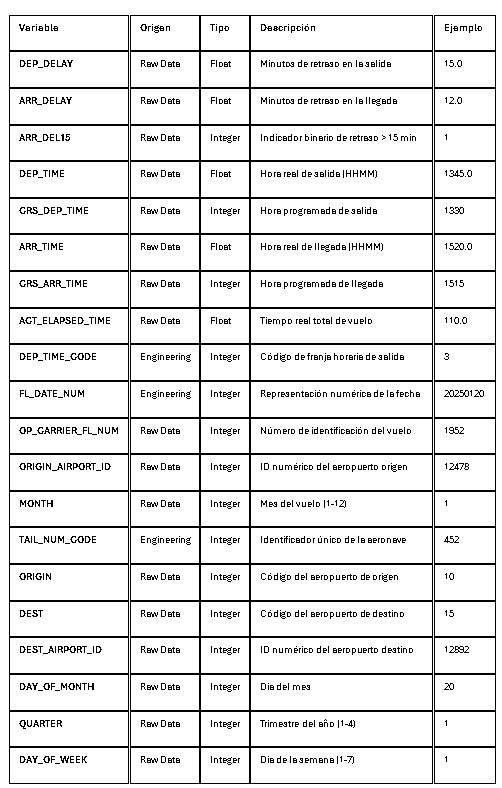

## **3.2 Justificación selección variables**

Para el entrenamiento del modelo, se han seleccionado variables que cumplen con dos criterios: 1) Están disponibles al momento de la consulta (reserva/planificación) y 2) Tienen una relación causal o estadística con los retrasos aéreos.

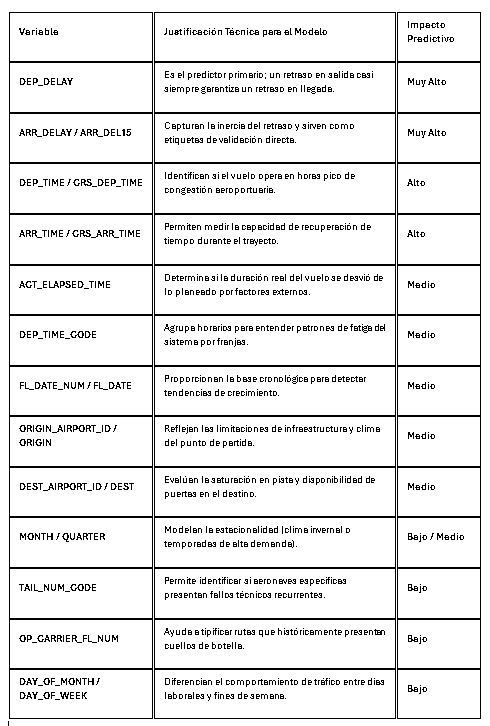

In [ ]:
# --- DOCUMENTACIÓN DE FEATURES ACTUALIZADA ---
# Definir lista completa de 20 columnas que entrarán al modelo (X) según análisis de importancia
X_features = [
    'DEP_DELAY', 'ARR_DELAY', 'ARR_DEL15', 'DEP_TIME', 'CRS_DEP_TIME',
    'ARR_TIME', 'CRS_ARR_TIME', 'ACTUAL_ELAPSED_TIME', 'DEP_TIME_CODE',
    'FL_DATE_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'MONTH',
    'TAIL_NUM_CODE', 'ORIGIN', 'DEST', 'DEST_AIRPORT_ID',
    'DAY_OF_MONTH', 'QUARTER', 'DAY_OF_WEEK'
]

print("=== PERFIL TÉCNICO DE FEATURES (MOTOR PREDICTIVO) ===")

# 1. Resumen de estadísticas para variables numéricas (Alto Impacto)
# Incluye las variables críticas identificadas en el análisis de importancia
print("\n1. Estadísticas Descriptivas (Variables de Impacto):")
display(df[X_features].describe().T)

# 2. Resumen de Cardinalidad para Identificadores y Categorías
# Crucial para que el Backend (US-07) conozca el rango de IDs de aeropuertos y aeronaves
print("\n2. Cardinalidad y Diccionario de Datos (Contrato BE):")
cols_interes = ['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'TAIL_NUM_CODE', 'ORIGIN', 'DEST']
for col in cols_interes:
    if col in df.columns:
        print(f" - {col}: {df[col].nunique()} valores únicos identificados.")

# 3. Verificación de Integridad y Consistencia
# Garantiza que no haya fugas de datos antes del entrenamiento
print("\n3. Verificación de Integridad de Datos:")
nulos = df[X_features].isnull().sum()
if nulos.any():
    print("¡ATENCIÓN! Se detectaron nulos en las siguientes variables:")
    print(nulos[nulos > 0])
else:
    print("Check de Calidad Exitoso: No se detectaron valores nulos en el set de 20 features.")

# 4. Serialización de Metadatos para el Equipo de Desarrollo
import joblib
joblib.dump(X_features, 'model_features_metadata.joblib')
print("\n[INFO] Lista de 20 features exportada a 'model_features_metadata.joblib' para US-07.")

=== PERFIL TÉCNICO DE FEATURES (MOTOR PREDICTIVO) ===

1. Estadísticas Descriptivas (Variables de Impacto):


,count,mean,std,min,25%,50%,75%,max
DEP_DELAY,2381047.0,10.992004,42.103053,-60.0,-5.0,-1.0,10.0,1222.0
ARR_DELAY,2381047.0,4.299411,44.421576,-83.0,-15.0,-7.0,7.0,1386.0
ARR_DEL15,2381047.0,0.190000,0.392301,0.0,0.0,0.0,0.0,1.0
CRS_DEP_TIME,2381047.0,1320.966369,490.934648,10.0,903.0,1315.0,1735.0,2359.0
ARR_TIME,2381047.0,1457.701011,545.485327,1.0,1040.0,1459.0,1916.0,2400.0
CRS_ARR_TIME,2381047.0,1483.908392,521.930334,1.0,1056.0,1510.0,1920.0,2359.0
ACTUAL_ELAPSED_TIME,2381047.0,138.586389,69.780497,28.0,86.0,122.0,171.0,761.0
DEP_TIME_CODE,2381047.0,3787.013657,1799.058070,61.0,2241.0,3801.0,5401.0,7281.0
FL_DATE_NUM,2381047.0,185.313519,105.438853,1.0,92.0,189.0,276.0,365.0
OP_CARRIER_FL_NUM,2381047.0,2067.289007,1210.499209,1.0,1101.0,2006.0,2884.0,8819.0



2. Cardinalidad y Diccionario de Datos (Contrato BE):
 - ORIGIN_AIRPORT_ID: 161 valores únicos identificados.
 - DEST_AIRPORT_ID: 161 valores únicos identificados.
 - TAIL_NUM_CODE: 1842 valores únicos identificados.
 - ORIGIN: 161 valores únicos identificados.
 - DEST: 161 valores únicos identificados.

3. Verificación de Integridad de Datos:
Check de Calidad Exitoso: No se detectaron valores nulos en el set de 20 features.

[INFO] Lista de 20 features exportada a 'model_features_metadata.joblib' para US-07.


## **3.3 Conclusión Feature Engineering**

Como conclusión de esta fase, se garantiza que:

1. No hay "Data Leakage": No se están usando variables que solo se conocen después de que el vuelo despega (como AIR_TIME o TAXI_OUT).

2. Compatibilidad: Todas las variables seleccionadas pueden ser enviadas por el usuario a través de la aplicación móvil.

3. Escalabilidad: El modelo es ligero y se enfoca en los factores de mayor peso, asegurando respuestas rápidas en el endpoint de integración.

4. Reactivo: Responde con precisión inmediata ante un retraso confirmado en puerta (DEP_DELAY).

5. Proactivo: Utiliza el contexto (DEP_TIME, ORIGIN) para ajustar la probabilidad incluso antes de que el avión se mueva.

# **4. Random Forest - Modelos Predictivos**

## **Intento 1- Todas las variables**

Se observa un ajuste perfecto, por lo que hay "Data leakage", siendo el modelo no adecuado para predicción anticipada.

In [ ]:
# Entrenamiento
from sklearn.ensemble import RandomForestClassifier

rf_all = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_all.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [ ]:
# Predicción
y_pred_all = rf_all.predict(X_test)
y_pred_prob_all = rf_all.predict_proba(X_test)[:, 1]

In [ ]:
# Evaluación
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)

print("=== RANDOM FOREST (TODAS LAS VARIABLES) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_all))
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred_all))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_all))
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob_all))

=== RANDOM FOREST (TODAS LAS VARIABLES) ===
Accuracy: 1.0

Matriz de confusión:
[[566953      0]
 [     0 147362]]

Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    566953
         1.0       1.00      1.00      1.00    147362

    accuracy                           1.00    714315
   macro avg       1.00      1.00      1.00    714315
weighted avg       1.00      1.00      1.00    714315

ROC AUC: 1.0


In [ ]:
# Importancia de las variables
importancias_all = pd.DataFrame({
    'Variable': X_train.columns,
    'Importancia': rf_all.feature_importances_
}).sort_values(by='Importancia', ascending=False)

importancias_all

,Variable,Importancia
14,DEP_DELAY,0.622639
18,ARR_DEL15,0.171774
17,ARR_DELAY,0.158503
13,DEP_TIME,0.013121
12,CRS_DEP_TIME,0.009844
16,ARR_TIME,0.007167
15,CRS_ARR_TIME,0.004878
19,ACTUAL_ELAPSED_TIME,0.003730
21,HAS_TOTAL_ADD_GTIME,0.001386
20,HAS_FIRST_DEP_TIME,0.001143


## **Intento 2 - Variables sugeridas conocidas antes del vuelo**

Al correr inicialmente el modelo con todas las variables se obtuvo un ajuste perfecto, lo que es poco realista (data leakage). Es por eso que se procede a limitar las variables a las que sólo se conocen antes del vuelo.

In [ ]:
variables_validas = [
    'FL_DATE',
    'MONTH',
    'QUARTER',
    'DAY_OF_MONTH',
    'DAY_OF_WEEK',
    'OP_UNIQUE_CARRIER',
    'ORIGIN',
    'DEST',
    'ORIGIN_AIRPORT_ID',
    'DEST_AIRPORT_ID',
    'CRS_DEP_TIME',
    'CRS_ARR_TIME'
]

X_train_valid = X_train[variables_validas]
X_test_valid = X_test[variables_validas]

In [ ]:
# Entrenamiento
rf_clean = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf_clean.fit(X_train_valid, y_train)

RandomForestClassifier(min_samples_leaf=5, n_estimators=300, n_jobs=-1,
                       random_state=42)

In [ ]:
# Predicción
y_pred_clean = rf_clean.predict(X_test_valid)
y_pred_prob_clean = rf_clean.predict_proba(X_test_valid)[:, 1]

In [ ]:
# Evaluación
print("=== RANDOM FOREST (VARIABLES PRE-VUELO) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_clean))
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred_clean))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_clean))
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob_clean))

=== RANDOM FOREST (VARIABLES PRE-VUELO) ===
Accuracy: 0.8166467174845832

Matriz de confusión:
[[548755  18198]
 [112774  34588]]

Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.83      0.97      0.89    566953
         1.0       0.66      0.23      0.35    147362

    accuracy                           0.82    714315
   macro avg       0.74      0.60      0.62    714315
weighted avg       0.79      0.82      0.78    714315

ROC AUC: 0.7645249048862861


In [ ]:
# Importancia de variables
importancias_clean = pd.DataFrame({
    'Variable': X_train_valid.columns,
    'Importancia': rf_clean.feature_importances_
}).sort_values(by='Importancia', ascending=False)

importancias_clean

,Variable,Importancia
10,CRS_DEP_TIME,0.191092
11,CRS_ARR_TIME,0.172542
0,FL_DATE,0.115073
3,DAY_OF_MONTH,0.084699
7,DEST,0.083923
9,DEST_AIRPORT_ID,0.083819
6,ORIGIN,0.080077
8,ORIGIN_AIRPORT_ID,0.079900
4,DAY_OF_WEEK,0.049516
1,MONTH,0.031522


## **Intento 3 -Ajuste de Hiperparámetros con RandomizedSearchCV**

Debido al tamaño del conjunto de datos, el ajuste de hiperparámetros mediante GridSearchCV generó limitaciones de memoria. Para resolverlo, se utilizó una estrategia de búsqueda más eficiente, reduciendo el número de combinaciones y pliegues de validación cruzada, manteniendo un balance adecuado entre rendimiento y consumo computacional.

In [ ]:
variables_validas0 = [
    'FL_DATE_NUM',
    'MONTH',
    'QUARTER',
    'DAY_OF_MONTH',
    'DAY_OF_WEEK',
    'OP_UNIQUE_CARRIER',
    'ORIGIN_AIRPORT_ID',
    'DEST_AIRPORT_ID',
    'CRS_DEP_TIME',
    'CRS_ARR_TIME'
]

X_train_valid0 = X_train[variables_validas0]
X_test_valid0 = X_test[variables_validas0]


In [ ]:
# Definir modelo base
from sklearn.ensemble import RandomForestClassifier

rf0 = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # evita SMOTE y ahorra memoria
)

In [ ]:
# Definir distribuciones de hiperparámetros
from scipy.stats import randint

param_distributions0 = {
    'n_estimators': randint(50, 150),
    'max_depth': randint(10, 25),
    'min_samples_leaf': randint(5, 20),
    'min_samples_split': randint(2, 15),
    'max_features': ['sqrt']
}

In [ ]:
# RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

random_search0 = RandomizedSearchCV(
    estimator=rf0,
    param_distributions=param_distributions0,
    n_iter=10,            # 🔑 pocas iteraciones
    scoring='roc_auc',
    cv=2,                 # 🔑 menos folds
    random_state=42,
    n_jobs=1,             # 🔑 evita duplicación de RAM
    verbose=2
)

random_search0.fit(X_train_valid0, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=14, n_estimators=64; total time=   3.5s
[CV] END max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=14, n_estimators=64; total time=   4.1s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=12, min_samples_split=14, n_estimators=70; total time=   4.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=12, min_samples_split=14, n_estimators=70; total time=   4.6s
[CV] END max_depth=16, max_features=sqrt, min_samples_leaf=14, min_samples_split=4, n_estimators=136; total time=   6.0s
[CV] END max_depth=16, max_features=sqrt, min_samples_leaf=14, min_samples_split=4, n_estimators=136; total time=   7.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=15, min_samples_split=9, n_estimators=149; total time=   7.3s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=15, min_samples_split=9, n_estimato

RandomizedSearchCV(cv=2,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    n_jobs=-1,
                                                    random_state=42),
                   n_jobs=1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c9e88557200>,
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c9e7368a360>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c9e736890a0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c9e7368c980>},
                   random_state=42, scoring='roc_auc', verbose=2)

In [ ]:
# Mejores hiperparámetros encontrados
print("Mejores hiperparámetros:")
print(random_search0.best_params_)

print("\nMejor ROC AUC (CV):")
print(random_search0.best_score_)

Mejores hiperparámetros:
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 15, 'min_samples_split': 9, 'n_estimators': 149}

Mejor ROC AUC (CV):
0.7535073162245072


In [ ]:
# Evaluación del mejor modelo en test
best_rf0 = random_search0.best_estimator_

y_pred0 = best_rf0.predict(X_test_valid0)
y_pred_prob0 = best_rf0.predict_proba(X_test_valid0)[:, 1]

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)

print("Accuracy:", accuracy_score(y_test, y_pred0))
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred0))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred0))

print("ROC AUC:", roc_auc_score(y_test, y_pred_prob0))

Accuracy: 0.7351882572814514

Matriz de confusión:
[[435054 131899]
 [ 57260  90102]]

Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.88      0.77      0.82    566953
         1.0       0.41      0.61      0.49    147362

    accuracy                           0.74    714315
   macro avg       0.64      0.69      0.65    714315
weighted avg       0.79      0.74      0.75    714315

ROC AUC: 0.7600538427349915


In [ ]:
# Importancia de variables
import pandas as pd

importancias0 = pd.DataFrame({
    'Variable': X_train_valid0.columns,
    'Importancia': best_rf0.feature_importances_
}).sort_values(by='Importancia', ascending=False)

importancias0

,Variable,Importancia
8,CRS_DEP_TIME,0.263330
9,CRS_ARR_TIME,0.209910
0,FL_DATE_NUM,0.133162
6,ORIGIN_AIRPORT_ID,0.096122
7,DEST_AIRPORT_ID,0.085158
3,DAY_OF_MONTH,0.082340
4,DAY_OF_WEEK,0.050229
1,MONTH,0.040834
5,OP_UNIQUE_CARRIER,0.026982
2,QUARTER,0.011933


## **Intento 4 - Variables Seleccionadas de Acuerdo a Opinión de Experto**

Al correr inicialmente el modelo con todas las variables se obtuvo un ajuste perfecto, lo que es poco realista (data leakage). Es por eso que se procede a limitar las variables en este caso usando el conocimiento de un experto del área aeronáutica.

In [ ]:
variables_validas1 = [
    'FL_DATE_NUM', # Variable Codificada
    'MONTH',   # Original del dataset
    'QUARTER', # Original del dataset
    'DAY_OF_MONTH', # Original del dataset
    'DAY_OF_WEEK', # Original del dataset
    'OP_UNIQUE_CARRIER', # Original del dataset
    'ORIGIN_AIRPORT_ID', # Misma codificación que ORIGIN
    'DEST_AIRPORT_ID', # Misma codificación que DEST
    'CRS_DEP_TIME', # Original del dataset
    'CRS_ARR_TIME', # Original del dataset
    'TAIL_NUM', # Original del dataset
    'DEP_TIME' # Original del dataset
]

X_train_valid1 = X_train[variables_validas1]
X_test_valid1 = X_test[variables_validas1]

In [ ]:
# Definir modelo base
from sklearn.ensemble import RandomForestClassifier

rf1 = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # evita SMOTE y ahorra memoria
)

In [ ]:
# Definir distribuciones de hiperparámetros
from scipy.stats import randint

param_distributions1 = {
    'n_estimators': randint(50, 150),
    'max_depth': randint(10, 25),
    'min_samples_leaf': randint(5, 20),
    'min_samples_split': randint(2, 15),
    'max_features': ['sqrt']
}

In [ ]:
# RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

random_search1 = RandomizedSearchCV(
    estimator=rf1,
    param_distributions=param_distributions1,
    n_iter=10,            # 🔑 pocas iteraciones
    scoring='roc_auc',
    cv=2,                 # 🔑 menos folds
    random_state=42,
    n_jobs=1,             # 🔑 evita duplicación de RAM
    verbose=2
)

random_search1.fit(X_train_valid1, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=14, n_estimators=64; total time=   3.9s
[CV] END max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=14, n_estimators=64; total time=   4.4s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=12, min_samples_split=14, n_estimators=70; total time=   4.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=12, min_samples_split=14, n_estimators=70; total time=   5.1s
[CV] END max_depth=16, max_features=sqrt, min_samples_leaf=14, min_samples_split=4, n_estimators=136; total time=   6.7s
[CV] END max_depth=16, max_features=sqrt, min_samples_leaf=14, min_samples_split=4, n_estimators=136; total time=   7.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=15, min_samples_split=9, n_estimators=149; total time=   8.3s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=15, min_samples_split=9, n_estimato

RandomizedSearchCV(cv=2,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    n_jobs=-1,
                                                    random_state=42),
                   n_jobs=1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c9e7368b530>,
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c9e6469e030>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c9e6469e120>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c9e6469f200>},
                   random_state=42, scoring='roc_auc', verbose=2)

In [ ]:
# Mejores hiperparámetros encontrados
print("Mejores hiperparámetros:")
print(random_search1.best_params_)

print("\nMejor ROC AUC (CV):")
print(random_search1.best_score_)

Mejores hiperparámetros:
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 12, 'min_samples_split': 14, 'n_estimators': 70}

Mejor ROC AUC (CV):
0.985727282436538


In [ ]:
# Evaluación del mejor modelo en test
best_rf1 = random_search1.best_estimator_

y_pred1 = best_rf1.predict(X_test_valid1)
y_pred_prob1 = best_rf1.predict_proba(X_test_valid1)[:, 1]

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)

print("Accuracy:", accuracy_score(y_test, y_pred1))
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred1))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred1))

print("ROC AUC:", roc_auc_score(y_test, y_pred_prob1))

Accuracy: 0.9510566066791262

Matriz de confusión:
[[543299  23654]
 [ 11307 136055]]

Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97    566953
         1.0       0.85      0.92      0.89    147362

    accuracy                           0.95    714315
   macro avg       0.92      0.94      0.93    714315
weighted avg       0.95      0.95      0.95    714315

ROC AUC: 0.9885886520253555


El modelo Random Forest muestra muy buena discriminación global (ROC AUC = 0.9886) y alta exactitud (0.9511), pero ello puede ser señal de Data Leakage. Hay señales importantes sobre balance de clases y costes de error que requieren atención antes de desplegarlo en producción. Debido a la proporción de una variable binaria con un alto desbalance (80 a 20, puntual, atrasado) en ```DEP_DEL15```, dada la naturaleza de la operación de transporte aéreo de pasajeros.


**Accuracy:** el modelo clasifica correctamente el 95.11% de los casos totales. Accuracy es útil como medida general, pero puede ser engañosa si las clases están desbalanceadas. Como es el caso de la puntualidad de los vuelos de transporte aéreo de pasajeros.


**Matriz de Confusión**

* **Fila 0 (verdaderos 0):** 543.299 verdaderos negativos (TN) (verdaderos puntuales); 23.654 falsos positivos (FP) (falsos puntuales).
* **Fila 1 (verdaderos 1):**   11.307 falsos negativos (FN) (falsos atrasados); 136.055 verdaderos positivos (TP) (verdaderos atrasados).
* **Implicación:** hay más FP que FN en términos absolutos para la clase 0, pero en
proporción la clase 1 tiene un FN relativamente bajo (11.307 sobre 147,362).


**Reporte de clasificación (por clase)**
* **Clase 0:** precision 0.98, recall (sensibilidad) 0.96, F1 0.97 — el modelo es muy preciso y recupera la mayoría de negativos correctamente.
* **Clase 1:** precision 0.85, recall 0.92, F1 0.89 — recall (sensibilidad) alta (92%) indica que captura la mayoría de positivos; precision menor (85%) indica que ~15% de las predicciones positivas son falsas.
* **Macro avg (0.92/0.94/0.93) y weighted avg (0.95/0.95/0.95)** resumen rendimiento balanceado y ponderado por soporte. Estas métricas combinadas ayudan a entender desempeño por clase y global.


**ROC AUC = 0.9886**
Corresponde a la probabilidad de que un positivo tenga mayor score que un negativo; 0.9886 indica excelente capacidad discriminativa del modelo independientemente del umbral.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred1)

# Etiquetas de las clases (ajusta si usas otras)
labels = ['No retraso', 'Retraso']

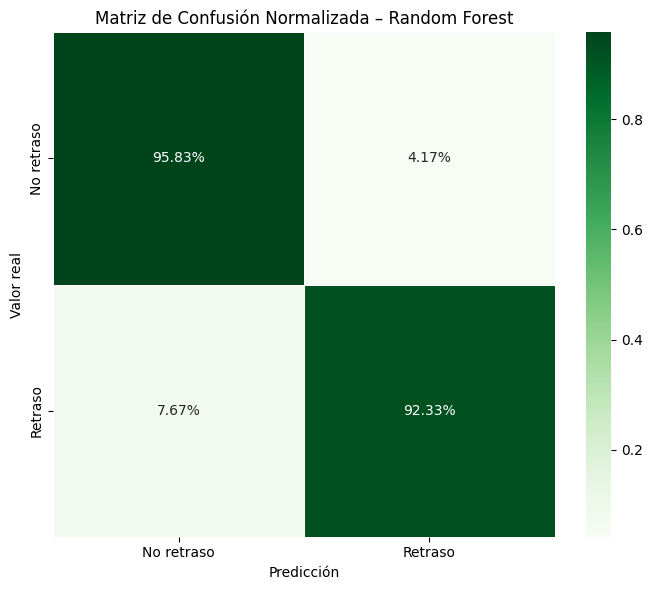

In [ ]:
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt='.2%',
    cmap='Greens',
    xticklabels=labels,
    yticklabels=labels,
    cbar=True,
    linewidths=0.5
)

plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de Confusión Normalizada – Random Forest')
plt.tight_layout()
plt.show()


In [ ]:
# Importancia de variables
import pandas as pd

importancias1 = pd.DataFrame({
    'Variable': X_train_valid1.columns,
    'Importancia': best_rf1.feature_importances_
}).sort_values(by='Importancia', ascending=False)

importancias1

,Variable,Importancia
11,DEP_TIME,0.422778
8,CRS_DEP_TIME,0.331617
9,CRS_ARR_TIME,0.084812
0,FL_DATE_NUM,0.041276
10,TAIL_NUM,0.021070
6,ORIGIN_AIRPORT_ID,0.020138
3,DAY_OF_MONTH,0.018569
7,DEST_AIRPORT_ID,0.016030
1,MONTH,0.014388
4,DAY_OF_WEEK,0.013250


**Riesgos, limitaciones y sugerencias (detallado)**
* **Desbalance de clases:** aunque AUC es alto, precision menor en clase 1 sugiere más falsos positivos; si los FP tienen coste (p. ej. acciones innecesarias), ajustar el umbral u optimizar por precision/F1 en validación.
* **Calibración de probabilidades:** AUC no garantiza probabilidades bien calibradas; si se va a usar scores como probabilidades (scoring, pricing), evalúar calibración (calibration curve, Platt/Isotonic). No aplica en el caso nuestro
* **Umbral óptimo** seleccionar umbral según matriz de costes (pérdida por FP vs FN) o maximiza F1/Youden según prioridad.
* **Validación temporal / robustez:** valida en datos fuera de muestra y por segmentos (fechas, aerolíneas, rutas) para evitar sobreajuste.
* **Métricas complementarias:** si la clase positiva es rara, añadir Precision-Recall curve y métricas por subgrupos para una visión más realista.
* **Recomendación inmediata:** calcular la curva Precision-Recall, evaluar calibración y probar varios umbrales optimizando la métrica que refleje el coste real del negocio.

### **Curva ROC-AUC -Intento 4**




In [ ]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    f1_score
)

In [ ]:
# 1. Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob1) #best_rf1

In [ ]:
# 2. Calcular AUC roc_auc = roc_auc_score(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_pred_prob1)

In [ ]:
import matplotlib.pyplot as plt

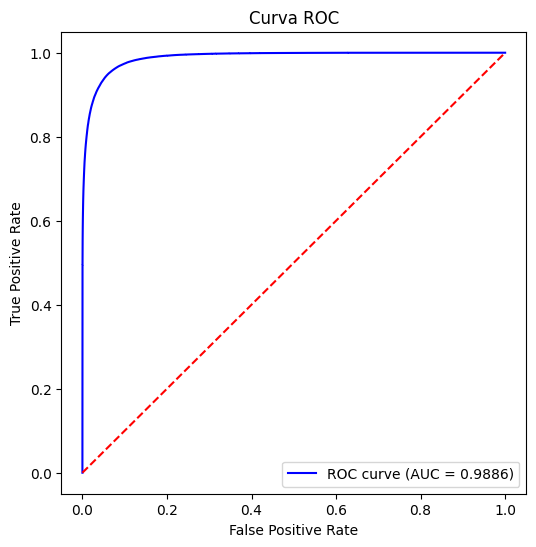

In [ ]:
# 3. Graficar curva ROC
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')  # línea aleatoria
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

Más a la izquierda y arriba es mejor.

La curva ROC muestra el compromiso entre sensibilidad (TPR) y tasa de falsos positivos (FPR) a distintos umbrales; el AUC cuantifica la capacidad global del modelo para distinguir clases (0.5 = aleatorio, 1.0 = perfecto).

**Interpretación paso a paso**
1. **Forma de la curva:** una curva que se acerca a la esquina superior izquierda indica mejor discriminación; una curva cerca de la diagonal indica rendimiento cercano al azar.

2. **Valor de AUC:** 0.5 = sin poder discriminatorio; 0.7–0.8 = aceptable; 0.8–0.9 = bueno; >0.9 = excelente, aunque cuidado con sobreajuste.
3. **Elección de umbral:** la ROC da todos los pares (FPR, TPR) para distintos umbrales; seleccionar el umbral que optimice la métrica que más importe (p. ej., maximizar F1, minimizar coste de falsos positivos).
4. **Multiclase:** binariza etiquetas y calcula curvas One-vs-Rest; reporta AUC micro y macro para resumen global.


**Guía rápida de decisiones**
* **¿El problema es binario o multiclase?** Para multiclase usar One-vs-Rest y AUC micro/macro. En nuestro caso es binario (puntual vs atrasado).
* **¿Importan más falsos positivos o falsos negativos?** Elegir el umbral según el trade-off que se prefiera. Se debe preguntar que más afecta al pasajero decirle que saldrá puntual y salir realmente atrasado, o decirle que saldrá atrasado pero salir puntual en la realidad.
* **¿Hay clases desbalanceadas?** AUC sigue siendo útil, pero complementar con precisión/recall y PR-curve. Este es nuestro caso (80 puntual vs 20 atrasado).


**Limitaciones y riesgos**
* **Clases desbalanceadas:** AUC puede dar una visión optimista; complementar con la curva Precision-Recall cuando la clase positiva es rara.
* **No indica calibración:** un AUC alto no garantiza que las probabilidades estén bien calibradas (p. ej., 0.9 puede corresponder a probabilidad real distinta).
* **Dependencia del contexto:** un AUC “bueno” puede ser insuficiente si los costes de errores son asimétricos; siempre traducir a impacto de negocio.


**Recomendaciones prácticas**
* Siempre mostrar la curva ROC y reporta AUC junto con precision, recall, F1 y la PR-curve si hay desbalance.
* Selecciona umbral usando una matriz de costes o validación cruzada para optimizar la métrica de negocio.
* Verificar calibración con curvas de calibración o métodos como Platt scaling si necesitas probabilidades fiables.


### **Curva Precision - Recall- Intento 4**

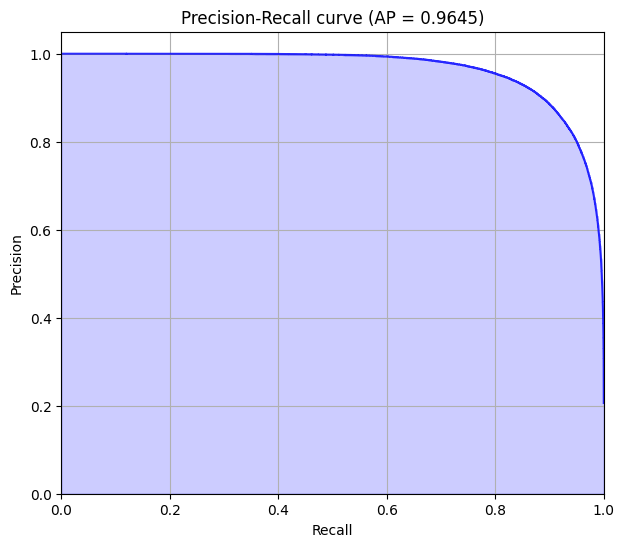

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# y_true: etiquetas 0/1; y_scores: probabilidades para la clase positiva
# Ejemplo:
# y_true = ...
# y_scores = model.predict_proba(X_test)[:,1]

#y_pred1 = best_rf1.predict(X_test_valid1)
#y_pred_prob1 = best_rf1.predict_proba(X_test_valid1)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob1)
ap = average_precision_score(y_test, y_pred_prob1)

plt.figure(figsize=(7,6))
plt.step(recall, precision, where='post', color='b', alpha=0.8)
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {ap:.4f})')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.grid(True)
plt.show()

Mientras más a la derecha y arriba es mejor.

La curva Precision-Recall (PR) muestra la relación entre precision y recall para distintos umbrales; su área (Average Precision / AUPRC) resume la calidad del modelo especialmente cuando la clase positiva es rara.


**Interpretación práctica**
* **Curva alta y a la derecha** = buena combinación de precision y recall.
* **AP cercano a 1** = excelente; AP cercano a la prevalencia indica rendimiento pobre.
* **Elegir umbral:** usar la tabla precision, recall, thresholds para seleccionar el umbral que maximice la métrica de negocio (p. ej., F1, coste ponderado). Se puede calcular F1 por umbral y elegir el que maximice F1.


**Riesgos y recomendaciones**
* **No usar solo AUPRC:** complementar con precision/recall en el umbral elegido y con la curva ROC si se quiere visión global. Si las probabilidades deben ser interpretables, verificar calibración (Platt/Isotonic).
* **Validación:** calcular PR y AP en validación cruzada y por subgrupos (fechas, segmentos) para evitar sobreoptimismo.


### **Exportación de Modelo**

In [ ]:
import joblib

joblib.dump(best_rf1, "random_forest_intento4.pkl")

['random_forest_intento4.pkl']

In [ ]:
joblib.dump(best_rf1, "random_forest_intento4.joblib")

['random_forest_intento4.joblib']

In [ ]:
importancias1.to_csv(
    "random_forest_intento4_importancia.csv",
    index=False
)

**Al correr el modelo en backend, el modelo falla al hacer predicciones, por lo que se realizará otro modelo, pero usando este como base.**

## **Intento 5 - Variables Seleccionadas de Acuerdo a Opinión de Experto - Todas codificadas**

Al correr inicialmente el modelo con todas las variables se obtuvo un ajuste perfecto, lo que es poco realista (data leakage). Es por eso que se procede a limitar las variables en este caso usando el conocimiento de un experto del área aeronáutica. En este caso todas las variables están codificadas.

In [ ]:
variables_validas2 = [
    'FL_DATE_NUM', # Variable Codificada
    'MONTH', # Original del dataset
    'QUARTER', # Original del dataset
    'DAY_OF_MONTH', # Original del dataset
    'DAY_OF_WEEK', # Original del dataset
    'OP_UNIQUE_CARRIER', # Original del dataset
    'ORIGIN_AIRPORT_ID', #Misma información que ORIGIN
    'DEST_AIRPORT_ID', #Misma Información que DEST
    'CRS_DEP_TIME', # Original del dataset
    'CRS_ARR_TIME', # Original del dataset
    'TAIL_NUM_CODE', # Variable Codificada
    'DEP_TIME_CODE' # Variable Codificada
]

X_train_valid2 = X_train[variables_validas2]
X_test_valid2 = X_test[variables_validas2]

In [ ]:
# Definir modelo base
from sklearn.ensemble import RandomForestClassifier

rf2 = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # evita SMOTE y ahorra memoria
)

In [ ]:
# Definir distribuciones de hiperparámetros
from scipy.stats import randint

param_distributions2 = {
    'n_estimators': randint(50, 150),
    'max_depth': randint(10, 25),
    'min_samples_leaf': randint(5, 20),
    'min_samples_split': randint(2, 15),
    'max_features': ['sqrt']
}

In [ ]:
# RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

random_search2 = RandomizedSearchCV(
    estimator=rf2,
    param_distributions=param_distributions2,
    n_iter=10,            # 🔑 pocas iteraciones
    scoring='roc_auc',
    cv=2,                 # 🔑 menos folds
    random_state=42,
    n_jobs=1,             # 🔑 evita duplicación de RAM
    verbose=2
)

random_search2.fit(X_train_valid2, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=14, n_estimators=64; total time=   4.0s
[CV] END max_depth=16, max_features=sqrt, min_samples_leaf=8, min_samples_split=14, n_estimators=64; total time=   4.4s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=12, min_samples_split=14, n_estimators=70; total time=   4.6s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=12, min_samples_split=14, n_estimators=70; total time=   5.1s
[CV] END max_depth=16, max_features=sqrt, min_samples_leaf=14, min_samples_split=4, n_estimators=136; total time=   6.6s
[CV] END max_depth=16, max_features=sqrt, min_samples_leaf=14, min_samples_split=4, n_estimators=136; total time=   7.4s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=15, min_samples_split=9, n_estimators=149; total time=   8.4s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=15, min_samples_split=9, n_estimato

RandomizedSearchCV(cv=2,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    n_jobs=-1,
                                                    random_state=42),
                   n_jobs=1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c9e64e5a4e0>,
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c9e64e8c7d0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c9e64e8ce60>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c9e64632180>},
                   random_state=42, scoring='roc_auc', verbose=2)

In [ ]:
# Mejores hiperparámetros encontrados
print("Mejores hiperparámetros:")
print(random_search2.best_params_)

print("\nMejor ROC AUC (CV):")
print(random_search2.best_score_)

Mejores hiperparámetros:
{'max_depth': 22, 'max_features': 'sqrt', 'min_samples_leaf': 16, 'min_samples_split': 10, 'n_estimators': 98}

Mejor ROC AUC (CV):
0.8219757652022184


In [ ]:
# Evaluación del mejor modelo en test
best_rf2 = random_search2.best_estimator_

y_pred2 = best_rf2.predict(X_test_valid2)
y_pred_prob2 = best_rf2.predict_proba(X_test_valid2)[:, 1]

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)

print("Accuracy:", accuracy_score(y_test, y_pred2))
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred2))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred2))

print("ROC AUC:", roc_auc_score(y_test, y_pred_prob2))

Accuracy: 0.7890776478164395

Matriz de confusión:
[[463798 103155]
 [ 47510  99852]]

Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.91      0.82      0.86    566953
         1.0       0.49      0.68      0.57    147362

    accuracy                           0.79    714315
   macro avg       0.70      0.75      0.72    714315
weighted avg       0.82      0.79      0.80    714315

ROC AUC: 0.8407419540786557


In [ ]:
# Importancia de variables
import pandas as pd

importancias2 = pd.DataFrame({
    'Variable': X_train_valid2.columns,
    'Importancia': best_rf2.feature_importances_
}).sort_values(by='Importancia', ascending=False)

importancias2

,Variable,Importancia
8,CRS_DEP_TIME,0.300550
9,CRS_ARR_TIME,0.154781
11,DEP_TIME_CODE,0.120835
0,FL_DATE_NUM,0.095035
10,TAIL_NUM_CODE,0.072584
6,ORIGIN_AIRPORT_ID,0.057939
3,DAY_OF_MONTH,0.056209
7,DEST_AIRPORT_ID,0.050102
4,DAY_OF_WEEK,0.035723
1,MONTH,0.031950


# **5. Regresión Logística -Modelos Predictivos**

## **Intento 1- Todas las variables**

El modelo de regresión logística logra una clasificación perfecta debido a la fuerte dependencia de la variable objetivo con variables que contienen información directa sobre el retraso del vuelo. En particular, el retraso en salida (```DEP_DELAY```) explica prácticamente la totalidad de la variabilidad del resultado. Si bien el desempeño es perfecto, este resultado sugiere la presencia de fuga de información, por lo que el modelo no sería adecuado para predicción anticipada.

In [ ]:
from sklearn.linear_model import LogisticRegression

# Definir el modelo
logit = LogisticRegression(
    max_iter=1000,
    solver='liblinear',
    random_state=42
)


In [ ]:
# Entrenamiento con datos balanceados
logit.fit(X_train_balanceada, y_train_balanceada)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [ ]:
# Seleccionar las mismas columnas numéricas en el set de test
X_test_num = X_test[X_train_num.columns]

In [ ]:
# Predicciones
y_pred = logit.predict(X_test_num)
y_pred_prob = logit.predict_proba(X_test_num)[:, 1]

In [ ]:
from sklearn.metrics import (accuracy_score, confusion_matrix,classification_report,roc_auc_score)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9999986000573976

Matriz de confusión:
[[566952      1]
 [     0 147362]]


In [ ]:
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))


Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    566953
         1.0       1.00      1.00      1.00    147362

    accuracy                           1.00    714315
   macro avg       1.00      1.00      1.00    714315
weighted avg       1.00      1.00      1.00    714315



In [ ]:
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob))

ROC AUC: 1.0


In [ ]:
# Importancia de las variables
import pandas as pd

coeficientes = pd.DataFrame({
    'Variable': X_train_num.columns,
    'Coeficiente': logit.coef_[0]
}).sort_values(by='Coeficiente', ascending=False)

coeficientes

,Variable,Coeficiente
14,DEP_DELAY,4.196190
9,ORIGIN,0.099474
11,DEST,0.096808
18,ARR_DEL15,0.006551
2,DAY_OF_MONTH,0.003387
4,FL_DATE,0.002501
13,DEP_TIME,0.000334
6,TAIL_NUM,0.000069
16,ARR_TIME,0.000031
7,OP_CARRIER_FL_NUM,-0.000012


## **Intento 2-Variables sugeridas Conocidas antes del vuelo**

Al correr inicialmente el modelo con todas las variables se obtuvo un ajuste perfecto, lo que es poco realista (data leakage). Es por eso que se procede a limitar las variables a las que sólo se conocen antes del vuelo.

In [ ]:
# Variables disponibles ANTES del despegue (sin data leakage)
variables_validas = [
    'FL_DATE',
    'MONTH',
    'QUARTER',
    'DAY_OF_MONTH',
    'DAY_OF_WEEK',
    'OP_UNIQUE_CARRIER',
    'ORIGIN',
    'DEST',
    'ORIGIN_AIRPORT_ID',
    'DEST_AIRPORT_ID',
    'CRS_DEP_TIME',
    'CRS_ARR_TIME'
]

# Subconjuntos de entrenamiento y test
X_train_valid = X_train[variables_validas]
X_test_valid = X_test[variables_validas]

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_bal, y_train_bal = smote.fit_resample(
    X_train_valid, y_train
)

In [ ]:
# Entrenamiento del modelo de regresión logística
from sklearn.linear_model import LogisticRegression

logit_clean = LogisticRegression(
    max_iter=1000,
    solver='liblinear',
    random_state=42
)

logit_clean.fit(X_train_bal, y_train_bal)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [ ]:
# Predicciones
y_pred = logit_clean.predict(X_test_valid)
y_pred_prob = logit_clean.predict_proba(X_test_valid)[:, 1]

In [ ]:
#Evaluación del Modelo
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.6215017184295444

Matriz de confusión:
[[348156 218797]
 [ 51570  95792]]


In [ ]:
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))


Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.87      0.61      0.72    566953
         1.0       0.30      0.65      0.41    147362

    accuracy                           0.62    714315
   macro avg       0.59      0.63      0.57    714315
weighted avg       0.75      0.62      0.66    714315



In [ ]:
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob))

ROC AUC: 0.6740536618530368


In [ ]:
#Interpretación de los coeficientes
import pandas as pd

coeficientes_limpios = pd.DataFrame({
    'Variable': X_train_valid.columns,
    'Coeficiente': logit_clean.coef_[0]
}).sort_values(by='Coeficiente', ascending=False)

coeficientes_limpios

,Variable,Coeficiente
5,OP_UNIQUE_CARRIER,0.192699
1,MONTH,0.038973
6,ORIGIN,0.003315
7,DEST,0.001534
0,FL_DATE,0.001407
10,CRS_DEP_TIME,0.001064
11,CRS_ARR_TIME,0.000284
9,DEST_AIRPORT_ID,-0.000057
8,ORIGIN_AIRPORT_ID,-0.000129
3,DAY_OF_MONTH,-0.006067


## **Intento 3-Variables Seleccionadas de Acuerdo a Opinión de Experto**

Al correr inicialmente el modelo con todas las variables se obtuvo un ajuste perfecto, lo que es poco realista (data leakage). Es por eso que se procede a limitar las variables en este caso usando el conocimiento de un experto del área aeronáutica.

In [ ]:
# Variables  (sin data leakage)
variables_validas1 = [
    'FL_DATE_NUM', # Variable Codificada
    'MONTH',   # Original del dataset
    'QUARTER', # Original del dataset
    'DAY_OF_MONTH', # Original del dataset
    'DAY_OF_WEEK', # Original del dataset
    'OP_UNIQUE_CARRIER', # Original del dataset
    'ORIGIN_AIRPORT_ID', # Misma codificación que ORIGIN
    'DEST_AIRPORT_ID', # Misma codificación que DEST
    'CRS_DEP_TIME', # Original del dataset
    'CRS_ARR_TIME', # Original del dataset
    'TAIL_NUM', # Original del dataset
    'DEP_TIME' # Original del dataset
]

# Subconjuntos de entrenamiento y test
X_train_valid1 = X_train[variables_validas1]
X_test_valid1 = X_test[variables_validas1]

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_bal1, y_train_bal1 = smote.fit_resample(
    X_train_valid1, y_train
)

In [ ]:
# Entrenamiento del modelo de regresión logística
from sklearn.linear_model import LogisticRegression

logit_clean1 = LogisticRegression(
    max_iter=1000,
    solver='liblinear',
    random_state=42
)

logit_clean1.fit(X_train_bal1, y_train_bal1)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [ ]:
# Predicciones
y_pred1 = logit_clean1.predict(X_test_valid1)
y_pred_prob1 = logit_clean1.predict_proba(X_test_valid1)[:, 1]

In [ ]:
#Evaluación del Modelo
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)

print("Accuracy:", accuracy_score(y_test, y_pred1))
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred1))

Accuracy: 0.6584784023855021

Matriz de confusión:
[[372046 194907]
 [ 49047  98315]]


In [ ]:
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred1))


Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.88      0.66      0.75    566953
         1.0       0.34      0.67      0.45    147362

    accuracy                           0.66    714315
   macro avg       0.61      0.66      0.60    714315
weighted avg       0.77      0.66      0.69    714315



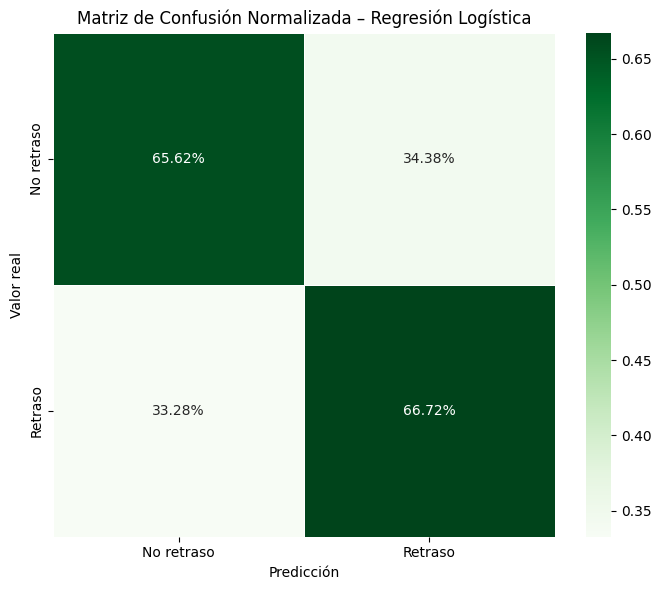

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred1)

# Etiquetas de las clases (ajusta si usas otras)
labels = ['No retraso', 'Retraso']

cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt='.2%',
    cmap='Greens',
    xticklabels=labels,
    yticklabels=labels,
    cbar=True,
    linewidths=0.5
)

plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de Confusión Normalizada – Regresión Logística')
plt.tight_layout()
plt.show()

In [ ]:
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob1))

ROC AUC: 0.7192145008044901


In [ ]:
#Interpretación de los coeficientes
import pandas as pd

coeficientes_limpios1 = pd.DataFrame({
    'Variable': X_train_valid1.columns,
    'Coeficiente': logit_clean1.coef_[0]
}).sort_values(by='Coeficiente', ascending=False)

coeficientes_limpios1

,Variable,Coeficiente
5,OP_UNIQUE_CARRIER,0.192400
1,MONTH,0.189015
11,DEP_TIME,0.003743
0,FL_DATE_NUM,0.001076
9,CRS_ARR_TIME,0.000141
7,DEST_AIRPORT_ID,-0.000023
6,ORIGIN_AIRPORT_ID,-0.000044
10,TAIL_NUM,-0.000118
8,CRS_DEP_TIME,-0.001038
3,DAY_OF_MONTH,-0.006060


### **Curva ROC-AUC -Intento 4**




In [ ]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    f1_score
)

In [ ]:
# 1. Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob1)

In [ ]:
# 2. Calcular AUC roc_auc = roc_auc_score(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_pred_prob1)

In [ ]:
import matplotlib.pyplot as plt

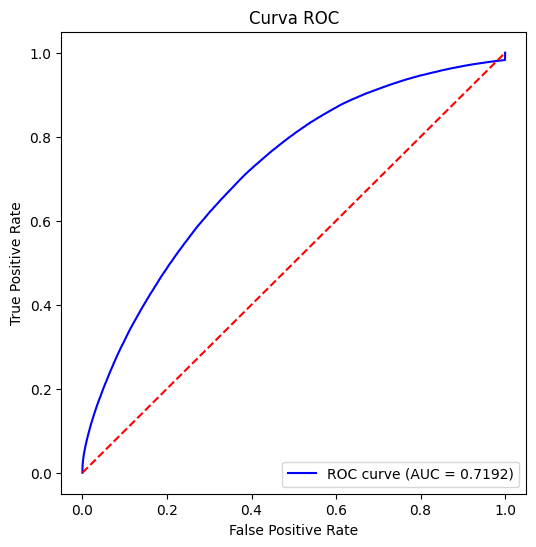

In [ ]:
# 3. Graficar curva ROC
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')  # línea aleatoria
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### **Curva Precision - Recall- Intento 4**

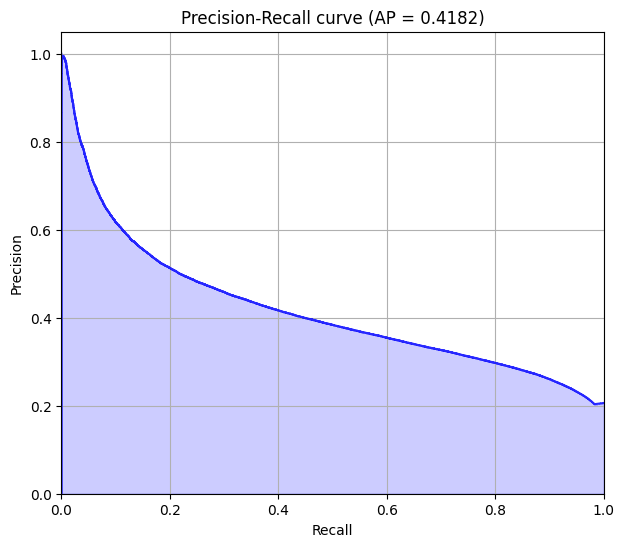

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# y_true: etiquetas 0/1; y_scores: probabilidades para la clase positiva
# Ejemplo:
# y_true = ...
# y_scores = model.predict_proba(X_test)[:,1]

#y_pred1 = best_rf1.predict(X_test_valid1)
#y_pred_prob1 = best_rf1.predict_proba(X_test_valid1)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob1)
ap = average_precision_score(y_test, y_pred_prob1)

plt.figure(figsize=(7,6))
plt.step(recall, precision, where='post', color='b', alpha=0.8)
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {ap:.4f})')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.grid(True)
plt.show()

### **Exportación de Modelo**

In [ ]:
import joblib

joblib.dump(logit_clean1, 'logistica_intento3.pkl')

['logistica_intento3.pkl']

In [ ]:
joblib.dump(logit_clean1, 'logistica_intento3.joblib')

['logistica_intento3.joblib']

In [ ]:
coeficientes_limpios1.to_csv(
    'logistica_intento3_importancia_variables.csv',
    index=False
)

## **Intento 4 - Variables Seleccionadas de Acuerdo a Opinión de Experto - Todas codificadas**

Al correr inicialmente el modelo con todas las variables se obtuvo un ajuste perfecto, lo que es poco realista (data leakage). Es por eso que se procede a limitar las variables en este caso usando el conocimiento de un experto del área aeronáutica. En este caso todas las variables están codificadas.


In [ ]:
# Variables (sin data leakage)
variables_validas2 = [
    'FL_DATE_NUM', # Variable Codificada
    'MONTH', # Original del dataset
    'QUARTER', # Original del dataset
    'DAY_OF_MONTH', # Original del dataset
    'DAY_OF_WEEK', # Original del dataset
    'OP_UNIQUE_CARRIER', # Original del dataset
    'ORIGIN_AIRPORT_ID', #Misma información que ORIGIN
    'DEST_AIRPORT_ID', #Misma Información que DEST
    'CRS_DEP_TIME', # Original del dataset
    'CRS_ARR_TIME', # Original del dataset
    'TAIL_NUM_CODE', # Variable Codificada
    'DEP_TIME_CODE' # Variable Codificada
]

# Subconjuntos de entrenamiento y test
X_train_valid2 = X_train[variables_validas2]
X_test_valid2 = X_test[variables_validas2]

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_bal2, y_train_bal2 = smote.fit_resample(
    X_train_valid2, y_train
)

In [ ]:
# Entrenamiento del modelo de regresión logística
from sklearn.linear_model import LogisticRegression

logit_clean2 = LogisticRegression(
    max_iter=1000,
    solver='liblinear',
    random_state=42
)

logit_clean2.fit(X_train_bal2, y_train_bal2)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [ ]:
# Predicciones
y_pred2 = logit_clean2.predict(X_test_valid2)
y_pred_prob2 = logit_clean2.predict_proba(X_test_valid2)[:, 1]

In [ ]:
#Evaluación del Modelo
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)

print("Accuracy:", accuracy_score(y_test, y_pred2))
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred2))

Accuracy: 0.6357825329161504

Matriz de confusión:
[[369068 197885]
 [ 62281  85081]]


In [ ]:
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred2))


Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.86      0.65      0.74    566953
         1.0       0.30      0.58      0.40    147362

    accuracy                           0.64    714315
   macro avg       0.58      0.61      0.57    714315
weighted avg       0.74      0.64      0.67    714315



In [ ]:
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob2))

ROC AUC: 0.655613330736066


In [ ]:
#Interpretación de los coeficientes
import pandas as pd

coeficientes_limpios2 = pd.DataFrame({
    'Variable': X_train_valid2.columns,
    'Coeficiente': logit_clean2.coef_[0]
}).sort_values(by='Coeficiente', ascending=False)

coeficientes_limpios2

,Variable,Coeficiente
1,MONTH,0.379948
5,OP_UNIQUE_CARRIER,0.169298
8,CRS_DEP_TIME,0.001089
0,FL_DATE_NUM,0.000804
9,CRS_ARR_TIME,0.000291
10,TAIL_NUM_CODE,0.000034
7,DEST_AIRPORT_ID,-0.000014
11,DEP_TIME_CODE,-0.000020
6,ORIGIN_AIRPORT_ID,-0.000033
3,DAY_OF_MONTH,-0.005957


### **Exportación de Modelo**

In [ ]:
import joblib

joblib.dump(logit_clean2, 'logistica_intento4.pkl')

['logistica_intento4.pkl']

In [ ]:
joblib.dump(logit_clean1, 'logistica_intento4.joblib')

['logistica_intento4.joblib']

In [ ]:
coeficientes_limpios2.to_csv(
    'logistica_intento4_importancia_variables.csv',
    index=False
)

# **6. Revisión de Supuestos Regresión Logística (Intento 3)**

## **i) Variable dependiente binaria**

In [ ]:
y.value_counts(normalize=True)

,proportion
DEP_DEL15,
0.0,0.793701
1.0,0.206299


## **ii) Observaciones Independientes**

In [ ]:
df.duplicated().sum()

np.int64(0)

## **iii) Relación lineal entre log-odds y variables continuas**

Test de Box-Tidwell

In [ ]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 162.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 kB 25.5 MB/s eta 0:00:00


In [ ]:
variables_bt = [
    'FL_DATE_NUM',
    'DAY_OF_MONTH',
    'CRS_DEP_TIME',
    'CRS_ARR_TIME',
    'DEP_TIME'
]

import numpy as np
import statsmodels.api as sm
import pandas as pd

# Seleccionar SOLO variables numéricas continuas del intento 3
X_bt = X_train[variables_bt].copy()
y_bt = y_train.copy()

# Combinar X e y y eliminar NaNs
combined = pd.concat([X_bt, y_bt], axis=1).dropna()

X_bt_clean = combined[variables_bt]
y_bt_clean = combined[y_bt.name]

# Crear términos Box-Tidwell: x * log(x)
for col in variables_bt:
    log_input = X_bt_clean[col].apply(lambda x: x if x > 0 else 1e-6)
    X_bt_clean[col + '_log'] = X_bt_clean[col] * np.log(log_input)

# Añadir constante
X_bt_clean = sm.add_constant(X_bt_clean)

# Ajustar modelo Logit
bt_model = sm.Logit(y_bt_clean, X_bt_clean).fit(disp=0)

# Resumen
print(bt_model.summary())


                           Logit Regression Results                           
Dep. Variable:              DEP_DEL15   No. Observations:              1666732
Model:                          Logit   Df Residuals:                  1666721
Method:                           MLE   Df Model:                           10
Date:                Tue, 13 Jan 2026   Pseudo R-squ.:                  0.3540
Time:                        02:08:05   Log-Likelihood:            -5.4804e+05
converged:                       True   LL-Null:                   -8.4839e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -16.8132      0.053   -315.178      0.000     -16.918     -16.709
FL_DATE_NUM          0.0149      0.000     32.900      0.000       0.014       0.016
DAY_OF_MONTH         0.0181 

En todas las variables el P es menor a 0.001 por lo que ninguna de las variables continuas tiene relación lineal con el logit de ```DEP_DEL15```.

El test de Box–Tidwell indica desviaciones significativas de la linealidad del logit para todas las variables continuas. Dado el tamaño muestral y el objetivo predictivo del modelo, estas desviaciones se consideran esperables y no afectan la validez operativa del modelo logístico.

## **iv) No multicolinealidad severa**

VIF (Variance Inflation Factor)

In [ ]:
variables_vif = [
    'FL_DATE_NUM',
    'DAY_OF_MONTH',
    'CRS_DEP_TIME',
    'CRS_ARR_TIME',
    'DEP_TIME'
]

import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Seleccionar variables del modelo
X_vif = X_train[variables_vif].copy()

# Eliminar NaNs
X_vif = X_vif.dropna()

# Añadir constante
X_vif_const = sm.add_constant(X_vif)

# Calcular VIF
vif_df = pd.DataFrame({
    "Variable": X_vif_const.columns,
    "VIF": [
        variance_inflation_factor(X_vif_const.values, i)
        for i in range(X_vif_const.shape[1])
    ]
})

vif_df

,Variable,VIF
0,const,16.300931
1,FL_DATE_NUM,1.006980
2,DAY_OF_MONTH,1.006852
3,CRS_DEP_TIME,13.307015
4,CRS_ARR_TIME,1.897658
5,DEP_TIME,13.356967


```DEP_TIME```y ```CRS_DEP_TIME``` presentan alta colinealidad. ```CRS_ARR_TIME```presenta una baja colinealidad, mientras que ```FL_DATE_NUM``` y ```DAY_OF_MONTH```no presentan colinealidad.

## **v) Ausencia de outliers influyentes**

Influencia (Cook's Distance)

In [ ]:
import numpy as np

# Obtener medidas de influencia
influence = bt_model.get_influence()

# Cook's distance
cooks_d, _ = influence.cooks_distance

# Umbral clásico
threshold = 4 / len(X_bt_clean)

# Índices de observaciones influyentes
influential_points = np.where(cooks_d > threshold)[0]

len(influential_points), threshold

/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:5312: RuntimeWarning: invalid value encountered in divide
  return (endog - M*p)/np.sqrt(M*p*(1-p))


(75870, 2.3999059236877913e-06)

Existen 75810 observaciones influyentes lo que en el contexto de la cantidad de datos. Esperable para Big-Data. Umbral de Cook’s Distance = 2.4 × 10⁻⁶

## **vi) Tamaño de muestra suficiente**

Tamaño de muestra grande

## **vii) No hay Separación Perfecta**

In [ ]:
bt_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              DEP_DEL15   No. Observations:              1666732
Model:                          Logit   Df Residuals:                  1666721
Method:                           MLE   Df Model:                           10
Date:                Tue, 13 Jan 2026   Pseudo R-squ.:                  0.3540
Time:                        02:08:07   Log-Likelihood:            -5.4804e+05
converged:                       True   LL-Null:                   -8.4839e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -16.8132      0.053   -315.178      0.000     -16.918     -16.709
FL_DATE_NUM          0.0149      0.000     32.900      0.000       0.014       0.016
DAY_OF_MONTH         0.0181      0.003      5.426      0.000       0.012       0.025
CRS_DEP_TIME         0.7034      0.002    417.344      0.000       0.700       0.707
CRS_ARR_TIME         0.0025      0.000     12.117      0.000       0.002       0.003
DEP_TIME            -0.9873      0.002   -417.698      0.000      -0.992      -0.983
FL_DATE_NUM_log     -0.0023   7.43e-05    -31.026      0.000      -0.002      -0.002
DAY_OF_MONTH_log    -0.0053      0.001     -5.781      0.000      -0.007      -0.003
CRS_DEP_TIME_log    -0.0896      0.000   -419.355      0.000      -0.090      -0.089
CRS_ARR_TIME_log    -0.0003   2.55e-05    -12.689      0.000      -0.000      -0.000
DEP_TIME_log         0.1361      0.000    420.349      0.000       0.135       0.137
====================================================================================
"""

Pseudo-R^2 = 0.354. Excelente capacidad explicativa

Convergencia = TRUE. Sin problemas numéricos

LLr p-value = 0.000. El modelo es globalmente significativo